# Cryptocurrency Sentiment Analysis: Predicting Bitcoin Price Movements

## Research Question
Can social media sentiment from Reddit, Telegram, YouTube, and news sources predict hourly Bitcoin price movements?

## Dataset
- Bitcoin hourly prices (Sept-Nov 2025)
- Social media text data: Reddit, Telegram, YouTube, Google News
- Fear & Greed Index

## Approach
1. Collect price and sentiment data
2. Train custom sentiment encoder + use CryptoBERT
3. Aggregate sentiment features hourly
4. Train classification models to predict price direction
5. Evaluate and compare results

# Cryptocurrency Sentiment Analysis: Predicting Bitcoin Price Movements

## Research Question
Can social media sentiment from Reddit, Telegram, YouTube, and news sources predict hourly Bitcoin price movements?

## Dataset
- Bitcoin hourly prices (Sept-Nov 2025)
- Social media text data: Reddit, Telegram, YouTube, Google News
- Fear & Greed Index

## Approach
1. Collect price and sentiment data
2. Train custom sentiment encoder + use CryptoBERT
3. Aggregate sentiment features hourly
4. Train classification models to predict price direction
5. Evaluate and compare results

In [ ]:
# CELL 1: Install Required Packages
# Install all dependencies needed for the analysis

import subprocess
import sys

packages = [
    'beautifulsoup4',
    'feedparser',
    'youtube-comment-downloader',
    'praw',
    'telethon',
    'nest_asyncio',
    'transformers',
    'torch',
    'scikit-learn',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn'
]

print("Installing required packages...")
for package in packages:
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', package])

print("All packages installed successfully!")

Installing required packages...
All packages installed successfully!


In [ ]:
# CELL 2: Import Libraries and Setup
# Import all necessary libraries for data collection, processing, and modeling

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import requests
from typing import List, Dict
import warnings
warnings.filterwarnings('ignore')

# ML and NLP libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Libraries imported successfully
PyTorch version: 2.9.0+cpu
Device: CPU


## Data Collection Strategy

To analyze sentiment's predictive power, we need data from multiple sources:

**Price Data**: Hourly Bitcoin prices from CryptoCompare API give us the target variable (whether price went up or down next hour)

**Social Media Data**: We'll collect text from Reddit, Telegram, and YouTube to capture market sentiment from different communities. Each platform has different user bases and discussion patterns.

**News Data**: Google News headlines provide more formal sentiment compared to social media

**Market Sentiment**: Fear & Greed Index gives us an established market sentiment metric to compare against our social media analysis

The following cells define classes for collecting data from each source. Each class handles API authentication, rate limiting, and data formatting.

In [ ]:
# CELL 3: Data Collection Classes
# Define classes to collect data from various sources: prices(Bitcoin prices), Reddit(Reddit posts), Telegram(Telegram messages), YouTube(YouTube comments), News(Google News)

class PriceDataCollector:
    """Collect Bitcoin price data from CryptoCompare API"""

    def __init__(self):
        self.base_url = "https://min-api.cryptocompare.com/data/v2"

    def get_historical_prices(self, symbol: str = 'BTC', limit: int = 2000):
        """Fetch hourly price data for specified cryptocurrency"""
        endpoint = f"{self.base_url}/histohour"
        params = {'fsym': symbol, 'tsym': 'USD', 'limit': min(limit, 2000)}

        try:
            response = requests.get(endpoint, params=params, timeout=30)
            data = response.json()

            if data['Response'] == 'Success':
                df = pd.DataFrame(data['Data']['Data'])
                df['timestamp'] = pd.to_datetime(df['time'], unit='s')
                df['price'] = df['close']
                df = df[['timestamp', 'open', 'high', 'low', 'close', 'volumefrom', 'price']]
                df.rename(columns={'volumefrom': 'volume'}, inplace=True)
                print(f"Collected {len(df)} hourly price points for {symbol}")
                return df
        except Exception as e:
            print(f"Error collecting prices: {e}")
            return pd.DataFrame()


class RedditDataCollector:
    """Collect posts from crypto-related subreddits using PRAW"""

    def __init__(self, client_id, client_secret, user_agent):
        self.client_id = client_id
        self.client_secret = client_secret
        self.user_agent = user_agent
        self.subreddits = ['CryptoCurrency', 'Bitcoin']

    def collect_posts(self, limit: int = 1000):
        """Collect recent posts from specified subreddits"""
        try:
            import praw
            reddit = praw.Reddit(
                client_id=self.client_id,
                client_secret=self.client_secret,
                user_agent=self.user_agent
            )

            all_posts = []
            for sub in self.subreddits:
                subreddit = reddit.subreddit(sub)
                for post in subreddit.new(limit=limit):
                    all_posts.append({
                        'timestamp': datetime.fromtimestamp(post.created_utc),
                        'text': f"{post.title} {post.selftext}",
                        'source': 'reddit'
                    })
                time.sleep(1)

            df = pd.DataFrame(all_posts)
            print(f"Collected {len(df)} Reddit posts")
            return df
        except Exception as e:
            print(f"Reddit collection error: {e}")
            return pd.DataFrame()


class TelegramDataCollector:
    """Collect messages from public Telegram crypto channels"""

    def __init__(self, api_id, api_hash, phone):
        self.api_id = api_id
        self.api_hash = api_hash
        self.phone = phone
        self.channels = ['bitcoin', 'Whale_alert_io', 'TradingView']

    def collect_messages(self, limit: int = 500):
        """Collect recent messages from Telegram channels"""
        try:
            from telethon import TelegramClient
            import asyncio
            import nest_asyncio
            nest_asyncio.apply()

            async def fetch():
                client = TelegramClient('session', self.api_id, self.api_hash)
                await client.start(phone=self.phone)

                all_messages = []
                for channel in self.channels:
                    try:
                        entity = await client.get_entity(channel)
                        messages = await client.get_messages(entity, limit=limit)

                        for msg in messages:
                            if msg.message:
                                all_messages.append({
                                    'timestamp': msg.date,
                                    'text': msg.message,
                                    'source': 'telegram'
                                })
                    except:
                        pass
                    time.sleep(2)

                await client.disconnect()
                return all_messages

            loop = asyncio.get_event_loop()
            messages = loop.run_until_complete(fetch())
            df = pd.DataFrame(messages)
            print(f"Collected {len(df)} Telegram messages")
            return df
        except Exception as e:
            print(f"Telegram collection error: {e}")
            return pd.DataFrame()


class YouTubeDataCollector:
    """Collect comments from crypto YouTube videos"""

    def collect_comments(self, search_query: str = 'bitcoin crypto', max_videos: int = 3):
        """Collect comments from YouTube videos about crypto"""
        try:
            import requests
            from youtube_comment_downloader import YoutubeCommentDownloader

            # Search for video IDs
            search_url = f"https://www.youtube.com/results?search_query={search_query.replace(' ', '+')}"
            headers = {'User-Agent': 'Mozilla/5.0'}
            response = requests.get(search_url, headers=headers, timeout=10)

            import re
            video_ids = re.findall(r'watch\?v=([a-zA-Z0-9_-]{11})', response.text)
            video_ids = list(set(video_ids))[:max_videos]

            downloader = YoutubeCommentDownloader()
            all_comments = []

            for vid_id in video_ids:
                try:
                    for comment in downloader.get_comments_from_url(f'https://www.youtube.com/watch?v={vid_id}'):
                        if len(all_comments) >= 500:
                            break
                        all_comments.append({
                            'timestamp': pd.to_datetime(comment.get('time', datetime.now())),
                            'text': comment['text'],
                            'source': 'youtube'
                        })
                except:
                    pass
                time.sleep(2)

            df = pd.DataFrame(all_comments)
            print(f"Collected {len(df)} YouTube comments")
            return df
        except Exception as e:
            print(f"YouTube collection error: {e}")
            return pd.DataFrame()


class GoogleNewsCollector:
    """Collect crypto news from Google News RSS feeds"""

    def collect_news(self, keywords: list = ['bitcoin', 'ethereum']):
        """Collect news articles from Google News RSS"""
        try:
            import feedparser
            from urllib.parse import quote

            all_news = []
            for keyword in keywords:
                query = quote(f"{keyword} cryptocurrency")
                url = f"https://news.google.com/rss/search?q={query}&hl=en-US&gl=US&ceid=US:en"
                feed = feedparser.parse(url)

                for entry in feed.entries[:50]:
                    pub_date = entry.get('published_parsed', None)
                    timestamp = datetime(*pub_date[:6]) if pub_date else datetime.now()

                    all_news.append({
                        'timestamp': timestamp,
                        'text': entry.title,
                        'source': 'google_news'
                    })
                time.sleep(1)

            df = pd.DataFrame(all_news).drop_duplicates(subset=['text'])
            print(f"Collected {len(df)} news articles")
            return df
        except Exception as e:
            print(f"News collection error: {e}")
            return pd.DataFrame()


class FearGreedCollector:
    """Collect Crypto Fear & Greed Index data"""

    def collect_index(self, limit: int = 90):
        """Fetch historical Fear & Greed Index values"""
        try:
            url = f"https://api.alternative.me/fng/?limit={limit}"
            response = requests.get(url)
            data = response.json()

            records = []
            for item in data['data']:
                records.append({
                    'timestamp': pd.to_datetime(int(item['timestamp']), unit='s'),
                    'fear_greed_value': int(item['value'])
                })

            df = pd.DataFrame(records)
            print(f"Collected {len(df)} days of Fear & Greed data")
            return df
        except Exception as e:
            print(f"Fear & Greed collection error: {e}")
            return pd.DataFrame()

print("Data collection classes defined successfully")

Data collection classes defined successfully


## Why Multiple Data Sources Matter

Different platforms capture different aspects of market sentiment:
- **Reddit**: Community discussions and analysis
- **Telegram**: Real-time alerts and whale watching
- **YouTube**: Influencer opinions and technical analysis
- **News**: Mainstream coverage and regulatory updates

By combining these sources, we get a more complete picture of overall market sentiment rather than relying on a single platform.

In [ ]:
# CELL 4: Collect All Data

print("="*60)
print("DATA COLLECTION PIPELINE")
print("="*60)

# 1. Collect price data
print("\n[1/6] Collecting Bitcoin price data...")
price_collector = PriceDataCollector()
prices_df = price_collector.get_historical_prices('BTC', limit=2000)

# 2. Collect Reddit data (YOUR WORKING CREDENTIALS)
print("\n[2/6] Collecting Reddit data...")
reddit_collector = RedditDataCollector(
    client_id='',
    client_secret='',
    user_agent='crypto_sentiment_v1'
)
reddit_df = reddit_collector.collect_posts(limit=3000)

# 3. Collect Telegram data (YOUR WORKING CREDENTIALS)
print("\n[3/6] Collecting Telegram data...")
telegram_collector = TelegramDataCollector(
    api_id=,
    api_hash='',
    phone=''
)
telegram_df = telegram_collector.collect_messages(limit=1500)

# 4. Collect YouTube data
print("\n[4/6] Collecting YouTube comments...")
youtube_collector = YouTubeDataCollector()
youtube_df = youtube_collector.collect_comments('bitcoin crypto', max_videos=3)

# 5. Collect Google News
print("\n[5/6] Collecting Google News...")
news_collector = GoogleNewsCollector()
news_df = news_collector.collect_news(['bitcoin', 'BTC'])

# 6. Collect Fear & Greed Index
print("\n[6/6] Collecting Fear & Greed Index...")
fg_collector = FearGreedCollector()
fear_greed_df = fg_collector.collect_index(limit=90)

print("\n" + "="*60)
print("COLLECTION SUMMARY")
print("="*60)
print(f"Price data points: {len(prices_df)}")
print(f"Reddit posts: {len(reddit_df)}")
print(f"Telegram messages: {len(telegram_df)}")
print(f"YouTube comments: {len(youtube_df)}")
print(f"News articles: {len(news_df)}")
print(f"Fear & Greed data: {len(fear_greed_df)}")
print("="*60)

DATA COLLECTION PIPELINE

[1/6] Collecting Bitcoin price data...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 2001 hourly price points for BTC

[2/6] Collecting Reddit data...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Collected 1944 Reddit posts

[3/6] Collecting Telegram data...
Collected 3845 Telegram messages

[4/6] Collecting YouTube comments...
Collected 0 YouTube comments

[5/6] Collecting Google News...
Collected 75 news articles

[6/6] Collecting Fear & Greed Index...
Collected 90 days of Fear & Greed data

COLLECTION SUMMARY
Price data points: 2001
Reddit posts: 1944
Telegram messages: 3845
YouTube comments: 0
News articles: 75
Fear & Greed data: 90


## Data Collection Results

We successfully collected data from most sources, though YouTube failed due to API limitations. The dataset includes:
- 2,001 hourly Bitcoin price points
- Several thousand social media posts and messages
- 90 days of Fear & Greed Index data

This gives us enough text samples to train a sentiment classifier and test whether sentiment can predict price movements.

## Next Step: Building Sentiment Encoders

Raw text can't be used directly in machine learning models. We need to convert text into sentiment scores first. We'll try two approaches:

1. **Custom Encoder**: Train our own classifier using TF-IDF and Logistic Regression
2. **CryptoBERT**: Use a pre-trained model designed specifically for cryptocurrency text

By comparing both approaches, we can see if domain-specific models (CryptoBERT) perform better than simpler custom models.

In [ ]:
# CELL 5: Load Twitter Sentiment Data + Augment with Crypto Examples
# Combining general Twitter sentiment with crypto-specific labeled examples

print("LOADING AND AUGMENTING TRAINING DATA")
print("="*60)

import pandas as pd

# Load the general Twitter training data
from google.colab import files

print("\nUpload the twitter_training.csv file:")
uploaded = files.upload()

# Load the CSV
labeled_data = pd.read_csv('twitter_training.csv',
                           names=['id', 'topic', 'sentiment', 'text'],
                           encoding='latin-1')

print(f"\nLoaded {len(labeled_data)} general tweets")

# Map sentiment to numeric labels
sentiment_map = {
    'Positive': 2,
    'Neutral': 1,
    'Negative': 0,
    'Irrelevant': 1
}

labeled_data['label'] = labeled_data['sentiment'].map(sentiment_map)
labeled_data = labeled_data[['text', 'label']].dropna()
labeled_data = labeled_data[labeled_data['text'].str.len() > 10]

# Sample 8,000 from general Twitter data
if len(labeled_data) > 8000:
    labeled_data = labeled_data.sample(8000, random_state=42)

print(f"Sampled {len(labeled_data)} general tweets")

# CREATE CRYPTO-SPECIFIC AUGMENTATION DATA
print("\nAdding crypto-specific training examples...")

crypto_negative = [
    # Crashes and dumps (need stronger negative signals)
    "Bitcoin crashing hard massive sell-off happening",
    "Crypto market dumping lost all my gains",
    "BTC plunging to new lows bearish trend",
    "Bitcoin crashes amid regulatory concerns",
    "Ethereum tanking this is brutal",
    "Portfolio down 30 percent crypto winter",
    "Liquidated again this market is ruthless",
    "Bitcoin crash continues no hope",
    "Market bleeding red panic selling",
    "Lost everything on this dip done with crypto",
    "BTC dropping below support bear market",
    "Major sell-off in cryptocurrency markets",
    "Price falling fast sold at bottom",
    "Market crash worse than expected",
    "Bearish sentiment everywhere dark times",
    "Crypto collapsing run while you can",
    "Bitcoin dead time to move on",
    "Market dumping hard panic selling everywhere",
    "Crypto winter is here bear market confirmed",

    # Scams and fears
    "Rug pull another scam project fails",
    "Exchange hacked my funds are gone",
    "Bitcoin bubble popping told you so",
    "Crypto banned by government over",
    "Regulatory crackdown killing market",
    "Tether scam about to explode",
    "Ponzi scheme exposed crypto fraud",
    "Wallet drained scammer got everything",
    "Project exit scammed investors left holding bags",
    "Crypto crash wiped out my savings",

    # FUD and panic
    "FUD everywhere Bitcoin going to zero",
    "Whales dumping retail getting rekt",
    "Smart money exiting crypto dead",
    "Government seizure Bitcoin illegal",
    "Energy FUD killing Bitcoin adoption",
    "China ban crushing crypto markets",
    "Regulatory pressure destroying prices",
    "Banks blocking crypto purchases bearish",
    "Mining ban environmental disaster narrative",
    "SEC lawsuit crypto security crackdown"
]

crypto_neutral = [
    # Price reports and technical updates
    "Bitcoin price currently at 95000 dollars",
    "Bitcoin price remains stable today",
    "Ethereum network processed transactions",
    "Bitcoin dominance at 48 percent today",
    "Blockchain upgrade announced",
    "Crypto exchange adds new trading pair",
    "Bitcoin mining difficulty adjusted",
    "Trading volume stable across exchanges",
    "Layer 2 scaling solution goes live",
    "Crypto market cap unchanged today",
    "New wallet update released",
    "Bitcoin hashrate remains steady",
    "Ethereum gas fees at average levels",
    "Crypto adoption study published",
    "Blockchain transaction confirmed",
    "Bitcoin block time normal",
    "Network congestion moderate levels",
    "Stablecoin supply unchanged",
    "DEX volume steady this week",
    "On-chain metrics show stability",

    # News without clear direction
    "SEC reviewing crypto regulations",
    "New cryptocurrency project launched",
    "Bitcoin conference scheduled next month",
    "Ethereum developer meeting tomorrow",
    "Crypto company raises funding",
    "Blockchain technology research published",
    "Central bank discusses digital currency",
    "Crypto tax guidelines updated",
    "New mining pool announced",
    "Bitcoin ATM installed in city",

    # Technical analysis neutral
    "BTC testing resistance level",
    "Support level holding steady",
    "Trading range between 90k and 95k",
    "Consolidation phase continues",
    "Sideways movement expected",
    "Price finding equilibrium",
    "Volume decreasing neutral signal",
    "Market waiting for catalyst",
    "Price discovery ongoing",
    "Range-bound trading continues"
]

crypto_positive = [
    # Rallies and pumps (need stronger positive signals)
    "Bitcoin mooning new ATH incoming",
    "Bitcoin rallies as institutional adoption increases",
    "Crypto pumping hard bullish momentum",
    "BTC breaking resistance moon time",
    "Crypto market shows strong bullish momentum",
    "Ethereum surging gains everywhere",
    "Bought the dip already up 20 percent",
    "Bitcoin to 100k bullish season",
    "Crypto rally continues amazing gains",
    "Portfolio up massively best decision",
    "Bitcoin adoption growing institutions buying",
    "Ethereum upgrade successful price pumping",
    "Bullish news everywhere moon soon",
    "BTC mooning new ATH incoming",
    "Market recovery strong green candles",

    # Institutional and adoption news
    "Major company announces Bitcoin holdings",
    "Institutional investment flowing into crypto",
    "Banks launching crypto services bullish",
    "Country adopts Bitcoin legal tender",
    "Fortune 500 company buys Bitcoin",
    "ETF approval Bitcoin mainstream",
    "Pension funds allocating crypto exposure",
    "Wall Street embracing digital assets",
    "Sovereign wealth fund buys Bitcoin",
    "Central bank exploring crypto reserves",

    # Community optimism
    "HODL strong believers will win",
    "Diamond hands paying off profits",
    "Best time to accumulate Bitcoin",
    "Smart money accumulating dips",
    "Long-term holders increasing positions",
    "Fundamentals stronger than ever",
    "Network growth exponential bullish",
    "Developer activity all-time highs",
    "User adoption accelerating rapidly",
    "Ecosystem expanding infrastructure growing",

    # Technical bullish signals
    "Golden cross formed on BTC chart",
    "Breakout above key resistance bullish",
    "Higher lows forming accumulation",
    "Bull flag pattern confirmed",
    "Volume surge confirming breakout",
    "MACD crossover buy signal",
    "RSI showing strength continuation",
    "Moving averages aligned bullish",
    "Momentum increasing upside potential",
    "Chart looking extremely bullish"
]

# Create augmentation dataframe
crypto_augment = []

for text in crypto_negative:
    crypto_augment.append({'text': text, 'label': 0})

for text in crypto_neutral:
    crypto_augment.append({'text': text, 'label': 1})

for text in crypto_positive:
    crypto_augment.append({'text': text, 'label': 2})

crypto_df = pd.DataFrame(crypto_augment)

print(f"\nCrypto-specific examples created:")
print(f"  Negative: {len(crypto_negative)}")
print(f"  Neutral: {len(crypto_neutral)}")
print(f"  Positive: {len(crypto_positive)}")
print(f"  Total: {len(crypto_df)}")

# Combine general Twitter + crypto-specific data
final_labeled_data = pd.concat([labeled_data, crypto_df], ignore_index=True)

print(f"\nFinal combined dataset: {len(final_labeled_data)} samples")
print(f"\nFinal Label Distribution:")
print(f"  Negative (0): {(final_labeled_data['label']==0).sum()} ({(final_labeled_data['label']==0).sum()/len(final_labeled_data)*100:.1f}%)")
print(f"  Neutral (1): {(final_labeled_data['label']==1).sum()} ({(final_labeled_data['label']==1).sum()/len(final_labeled_data)*100:.1f}%)")
print(f"  Positive (2): {(final_labeled_data['label']==2).sum()} ({(final_labeled_data['label']==2).sum()/len(final_labeled_data)*100:.1f}%)")

# Show examples from crypto data
print(f"\nCrypto-Specific Sample Examples:")
for label_val, label_name in [(0, 'Negative'), (1, 'Neutral'), (2, 'Positive')]:
    sample = crypto_df[crypto_df['label']==label_val].sample(1).iloc[0]
    print(f"  {label_name}: '{sample['text'][:80]}'")

# Split train/test
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    final_labeled_data['text'].values,
    final_labeled_data['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=final_labeled_data['label'].values
)

print(f"\nSplit into:")
print(f"  Training: {len(train_texts)} samples ({len(train_texts)-len(labeled_data)*0.8:.0f} crypto + {len(labeled_data)*0.8:.0f} general)")
print(f"  Testing: {len(test_texts)} samples")

# Train Custom Encoder with enhanced data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

print("\nTraining Enhanced Custom Encoder...")
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), min_df=2)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

custom_encoder = LogisticRegression(max_iter=1000, multi_class='multinomial', C=1.0)
custom_encoder.fit(X_train, train_labels)

# Evaluate
train_acc = custom_encoder.score(X_train, train_labels)
test_acc = custom_encoder.score(X_test, test_labels)

print(f"\nEnhanced Custom Encoder Performance:")
print(f"  Training accuracy: {train_acc:.3f}")
print(f"  Test accuracy: {test_acc:.3f}")

# Test on the some examples
print(f"\nTesting some Examples:")
test_examples = [
    ("Bitcoin crashes amid regulatory concerns", "Negative"),
    ("Bitcoin rallies as institutional adoption increases", "Positive"),
    ("Crypto market shows strong bullish momentum", "Positive"),
    ("BTC mooning, new ATH incoming!", "Positive"),
]

for text, expected in failed_examples:
    X = vectorizer.transform([text])
    pred = custom_encoder.predict(X)[0]
    proba = custom_encoder.predict_proba(X)[0]
    predicted_label = ['Negative', 'Neutral', 'Positive'][pred]
    score = proba[2] - proba[0]

    status = "CORRECT" if predicted_label == expected else "WRONG"
    print(f"\n  '{text[:50]}'")
    print(f"    Expected: {expected} | Predicted: {predicted_label} ({status})")
    print(f"    Score: {score:+.3f} (neg:{proba[0]:.2f}, neu:{proba[1]:.2f}, pos:{proba[2]:.2f})")

print("\nEnhanced custom encoder trained successfully!")

LOADING AND AUGMENTING TRAINING DATA

Upload the twitter_training.csv file:


Saving twitter_training.csv to twitter_training (3).csv

Loaded 74682 general tweets
Sampled 8000 general tweets

Adding crypto-specific training examples...

Crypto-specific examples created:
  Negative: 39
  Neutral: 40
  Positive: 45
  Total: 124

Final combined dataset: 8124 samples

Final Label Distribution:
  Negative (0): 2426 (29.9%)
  Neutral (1): 3422 (42.1%)
  Positive (2): 2276 (28.0%)

Crypto-Specific Sample Examples:
  Negative: 'SEC lawsuit crypto security crackdown'
  Neutral: 'Range-bound trading continues'
  Positive: 'Bought the dip already up 20 percent'

Split into:
  Training: 6499 samples (99 crypto + 6400 general)
  Testing: 1625 samples

Training Enhanced Custom Encoder...

Enhanced Custom Encoder Performance:
  Training accuracy: 0.842
  Test accuracy: 0.648

Testing some Examples:

  'Bitcoin crashes amid regulatory concerns'
    Expected: Negative | Predicted: Negative (CORRECT)
    Score: -0.150 (neg:0.42, neu:0.30, pos:0.27)

  'Bitcoin rallies as institut

## Custom Encoder Performance

Our custom sentiment encoder achieved 64.8% test accuracy at classifying sentiment, which is reasonably good for a simple TF-IDF + Logistic Regression approach.

The encoder was trained on general Twitter sentiment data plus cryptocurrency-specific examples. This hybrid approach lets it understand both general sentiment patterns and crypto-specific language like "mooning" or "bear market."

**Key Question**: Will this 64.8% sentiment classification accuracy translate into good price prediction? Let's find out after we compare it with CryptoBERT.

In [ ]:
# CELL 6: Load CryptoBERT (Crypto-Specific) and Compare with Custom Encoder
# CryptoBERT is trained specifically on cryptocurrency text, unlike FinBERT

print("LOADING CRYPTOBERT - CRYPTO-SPECIFIC SENTIMENT MODEL")
print("="*60)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load CryptoBERT model and tokenizer
print("\nLoading CryptoBERT model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cryptobert_tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")
cryptobert_model = AutoModelForSequenceClassification.from_pretrained("ElKulako/cryptobert")
cryptobert_model.to(device)
cryptobert_model.eval()

print("CryptoBERT loaded successfully!")
print(f"Device: {device}")

def get_cryptobert_sentiment(text):
    """Get sentiment from CryptoBERT model"""
    try:
        # Tokenize
        inputs = cryptobert_tokenizer(text[:512], return_tensors="pt", truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get predictions
        with torch.no_grad():
            outputs = cryptobert_model(**inputs)
            logits = outputs.logits
            probs = F.softmax(logits, dim=-1)[0].cpu().numpy()

        # CryptoBERT uses 3 classes: 0=negative, 1=neutral, 2=positive
        negative = float(probs[0])
        neutral = float(probs[1])
        positive = float(probs[2])

        sentiment_score = positive - negative

        return {
            'sentiment_score': sentiment_score,
            'negative': negative,
            'neutral': neutral,
            'positive': positive
        }
    except Exception as e:
        print(f"Error processing: {e}")
        return {
            'sentiment_score': 0,
            'negative': 0.33,
            'neutral': 0.34,
            'positive': 0.33
        }

def get_custom_sentiment(text):
    """Get sentiment from our custom encoder"""
    X = vectorizer.transform([text])
    proba = custom_encoder.predict_proba(X)[0]

    sentiment_score = proba[2] - proba[0]  # Range: -1 to 1

    return {
        'sentiment_score': sentiment_score,
        'negative': proba[0],
        'neutral': proba[1],
        'positive': proba[2]
    }

# Compare both encoders on crypto-specific test samples
print("\nCOMPARISON: Custom Encoder vs CryptoBERT")
print("="*60)

comparison_samples = [
    "Bitcoin rallies as institutional adoption increases",
    "Bitcoin crashes amid regulatory concerns",
    "Bitcoin price remains stable today",
    "Crypto market shows strong bullish momentum",
    "Major sell-off in cryptocurrency markets",
    "BTC mooning, new ATH incoming!",
    "Crypto winter is here, bear market confirmed",
    "Ethereum upgrade successful, price pumping",
    "Market dumping hard, panic selling everywhere",
    "Bitcoin dominance at 48 percent today"
]

for sample in comparison_samples:
    custom_result = get_custom_sentiment(sample)
    crypto_result = get_cryptobert_sentiment(sample)

    print(f"\nText: '{sample}'")
    print(f"  Custom:     score={custom_result['sentiment_score']:+.3f} (neg:{custom_result['negative']:.2f}, neu:{custom_result['neutral']:.2f}, pos:{custom_result['positive']:.2f})")
    print(f"  CryptoBERT: score={crypto_result['sentiment_score']:+.3f} (neg:{crypto_result['negative']:.2f}, neu:{crypto_result['neutral']:.2f}, pos:{crypto_result['positive']:.2f})")

print("\nBoth encoders loaded and compared successfully!")

LOADING CRYPTOBERT - CRYPTO-SPECIFIC SENTIMENT MODEL

Loading CryptoBERT model...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CryptoBERT loaded successfully!
Device: cpu

COMPARISON: Custom Encoder vs CryptoBERT

Text: 'Bitcoin rallies as institutional adoption increases'
  Custom:     score=-0.006 (neg:0.31, neu:0.39, pos:0.30)
  CryptoBERT: score=+0.342 (neg:0.02, neu:0.61, pos:0.37)

Text: 'Bitcoin crashes amid regulatory concerns'
  Custom:     score=-0.150 (neg:0.42, neu:0.30, pos:0.27)
  CryptoBERT: score=-0.293 (neg:0.37, neu:0.55, pos:0.08)

Text: 'Bitcoin price remains stable today'
  Custom:     score=+0.264 (neg:0.13, neu:0.47, pos:0.40)
  CryptoBERT: score=+0.414 (neg:0.01, neu:0.57, pos:0.42)

Text: 'Crypto market shows strong bullish momentum'
  Custom:     score=+0.513 (neg:0.17, neu:0.14, pos:0.69)
  CryptoBERT: score=+0.406 (neg:0.00, neu:0.59, pos:0.41)

Text: 'Major sell-off in cryptocurrency markets'
  Custom:     score=-0.330 (neg:0.49, neu:0.34, pos:0.16)
  CryptoBERT: score=-0.472 (neg:0.48, neu:0.51, pos:0.01)

Text: 'BTC mooning, new ATH incoming!'
  Custom:     score=+0.101 (neg:0.36

## Comparing Custom vs CryptoBERT

We now have two sentiment encoders:
- **Custom**: Simple but trained on our specific labeled data
- **CryptoBERT**: Complex transformer model pre-trained on crypto text

The comparison on test samples shows how each encoder interprets crypto-specific language. This will help us understand which approach better captures sentiment that might predict prices.

Now we'll apply both encoders to all our collected social media data to create sentiment features for price prediction.

In [ ]:
# CELL 7: Encode All Collected Text Data with Both Encoders
# Apply both Custom and CryptoBERT sentiment encoders to social media data

print("ENCODING SENTIMENT FOR ALL DATA")
print("="*60)

# Combine all text data
all_text_data = []

for df, source in [(reddit_df, 'reddit'), (telegram_df, 'telegram'),
                    (youtube_df, 'youtube'), (news_df, 'google_news')]:
    if not df.empty and 'text' in df.columns:
        df_copy = df.copy()
        df_copy['source'] = source
        all_text_data.append(df_copy[['timestamp', 'text', 'source']])

if all_text_data:
    combined_text = pd.concat(all_text_data, ignore_index=True)

    # FIX: Convert timestamp and remove timezone
    combined_text['timestamp'] = pd.to_datetime(combined_text['timestamp'], utc=True).dt.tz_localize(None)



    # Filter for Bitcoin-specific content only
    print("\nFILTERING FOR BITCOIN-SPECIFIC CONTENT")
    print("="*60)

    # Define Bitcoin keywords (case-insensitive)
    bitcoin_keywords = [
        'bitcoin', 'btc', 'satoshi', 'sats',
        'btcusd', 'btc/usd', 'xbt',
        'bitcoin price', 'bitcoin market',
        'hodl bitcoin', 'bitcoin mining'
    ]

    def is_bitcoin_related(text):
        """Check if text mentions Bitcoin"""
        text_lower = str(text).lower()
        return any(keyword in text_lower for keyword in bitcoin_keywords)

    # Filter the data
    print(f"Before filtering: {len(combined_text)} items")

    combined_text['is_bitcoin'] = combined_text['text'].apply(is_bitcoin_related)
    combined_text = combined_text[combined_text['is_bitcoin']].copy()
    combined_text = combined_text.drop('is_bitcoin', axis=1)

    print(f"After filtering: {len(combined_text)} items")
    print(f"Removed: {len(combined_text) - len(combined_text)} non-Bitcoin items")

    # Show breakdown by source
    print("\nBitcoin-specific items by source:")
    for source in combined_text['source'].unique():
        count = (combined_text['source'] == source).sum()
        print(f"  {source}: {count}")

    print(f"\nTotal text samples to encode: {len(combined_text)}")
    print(f"  Reddit: {(combined_text['source']=='reddit').sum()}")
    print(f"  Telegram: {(combined_text['source']=='telegram').sum()}")
    print(f"  YouTube: {(combined_text['source']=='youtube').sum()}")
    print(f"  News: {(combined_text['source']=='google_news').sum()}")

    # Encode with Custom Encoder
    print("\nEncoding with Custom Encoder...")
    custom_sentiments = []
    for idx, row in combined_text.iterrows():
        text = str(row['text'])[:512]
        sentiment = get_custom_sentiment(text)
        custom_sentiments.append(sentiment)
        if (idx + 1) % 500 == 0:
            print(f"  Processed {idx + 1}/{len(combined_text)} samples")

    combined_text['custom_score'] = [s['sentiment_score'] for s in custom_sentiments]
    combined_text['custom_negative'] = [s['negative'] for s in custom_sentiments]
    combined_text['custom_neutral'] = [s['neutral'] for s in custom_sentiments]
    combined_text['custom_positive'] = [s['positive'] for s in custom_sentiments]

    # Encode with CryptoBERT
    print("\nEncoding with CryptoBERT...")
    cryptobert_sentiments = []
    for idx, row in combined_text.iterrows():
        text = str(row['text'])[:512]
        sentiment = get_cryptobert_sentiment(text)
        cryptobert_sentiments.append(sentiment)
        if (idx + 1) % 500 == 0:
            print(f"  Processed {idx + 1}/{len(combined_text)} samples")

    combined_text['cryptobert_score'] = [s['sentiment_score'] for s in cryptobert_sentiments]
    combined_text['cryptobert_negative'] = [s['negative'] for s in cryptobert_sentiments]
    combined_text['cryptobert_neutral'] = [s['neutral'] for s in cryptobert_sentiments]
    combined_text['cryptobert_positive'] = [s['positive'] for s in cryptobert_sentiments]

    print("\nSentiment Statistics:")
    print(f"\nCustom Encoder:")
    print(f"  Mean score: {combined_text['custom_score'].mean():.3f}")
    print(f"  Std dev: {combined_text['custom_score'].std():.3f}")
    print(f"  Positive: {(combined_text['custom_score'] > 0.1).sum()} ({(combined_text['custom_score'] > 0.1).sum()/len(combined_text)*100:.1f}%)")
    print(f"  Negative: {(combined_text['custom_score'] < -0.1).sum()} ({(combined_text['custom_score'] < -0.1).sum()/len(combined_text)*100:.1f}%)")

    print(f"\nCryptoBERT:")
    print(f"  Mean score: {combined_text['cryptobert_score'].mean():.3f}")
    print(f"  Std dev: {combined_text['cryptobert_score'].std():.3f}")
    print(f"  Positive: {(combined_text['cryptobert_score'] > 0.1).sum()} ({(combined_text['cryptobert_score'] > 0.1).sum()/len(combined_text)*100:.1f}%)")
    print(f"  Negative: {(combined_text['cryptobert_score'] < -0.1).sum()} ({(combined_text['cryptobert_score'] < -0.1).sum()/len(combined_text)*100:.1f}%)")

    print("\nAll text data encoded successfully!")
else:
    print("No text data to encode")
    combined_text = pd.DataFrame()

ENCODING SENTIMENT FOR ALL DATA

FILTERING FOR BITCOIN-SPECIFIC CONTENT
Before filtering: 5864 items
After filtering: 2719 items
Removed: 0 non-Bitcoin items

Bitcoin-specific items by source:
  reddit: 958
  telegram: 1707
  google_news: 54

Total text samples to encode: 2719
  Reddit: 958
  Telegram: 1707
  YouTube: 0
  News: 54

Encoding with Custom Encoder...
  Processed 1000/2719 samples
  Processed 1500/2719 samples
  Processed 2000/2719 samples
  Processed 2500/2719 samples
  Processed 3000/2719 samples
  Processed 4000/2719 samples
  Processed 4500/2719 samples

Encoding with CryptoBERT...
  Processed 1000/2719 samples
  Processed 1500/2719 samples
  Processed 2000/2719 samples
  Processed 2500/2719 samples
  Processed 3000/2719 samples
  Processed 4000/2719 samples
  Processed 4500/2719 samples

Sentiment Statistics:

Custom Encoder:
  Mean score: -0.055
  Std dev: 0.189
  Positive: 486 (17.9%)
  Negative: 1082 (39.8%)

CryptoBERT:
  Mean score: 0.315
  Std dev: 0.426
  Positi

## Sentiment Encoding Complete

All social media posts have now been processed through both encoders. Each post has:
- A sentiment score (negative to positive)
- Probability distributions for negative/neutral/positive classes

**Critical Statistics to Note**:
- Custom encoder mean score
- CryptoBERT mean score  
- Distribution of positive vs negative sentiment

These sentiment scores will be aggregated by hour and used as features to predict whether Bitcoin's price goes up or down in the next hour.

EXPLORATORY DATA ANALYSIS

DATA COVERAGE BY SOURCE:
Total text samples: 2719
  telegram: 1707 (62.8%)
  reddit: 958 (35.2%)
  google_news: 54 (2.0%)

Hourly sentiment coverage:
  Hours with data: 1590/2001 (79.5%)
  Avg items per hour: 1.71
  Max items in one hour: 11


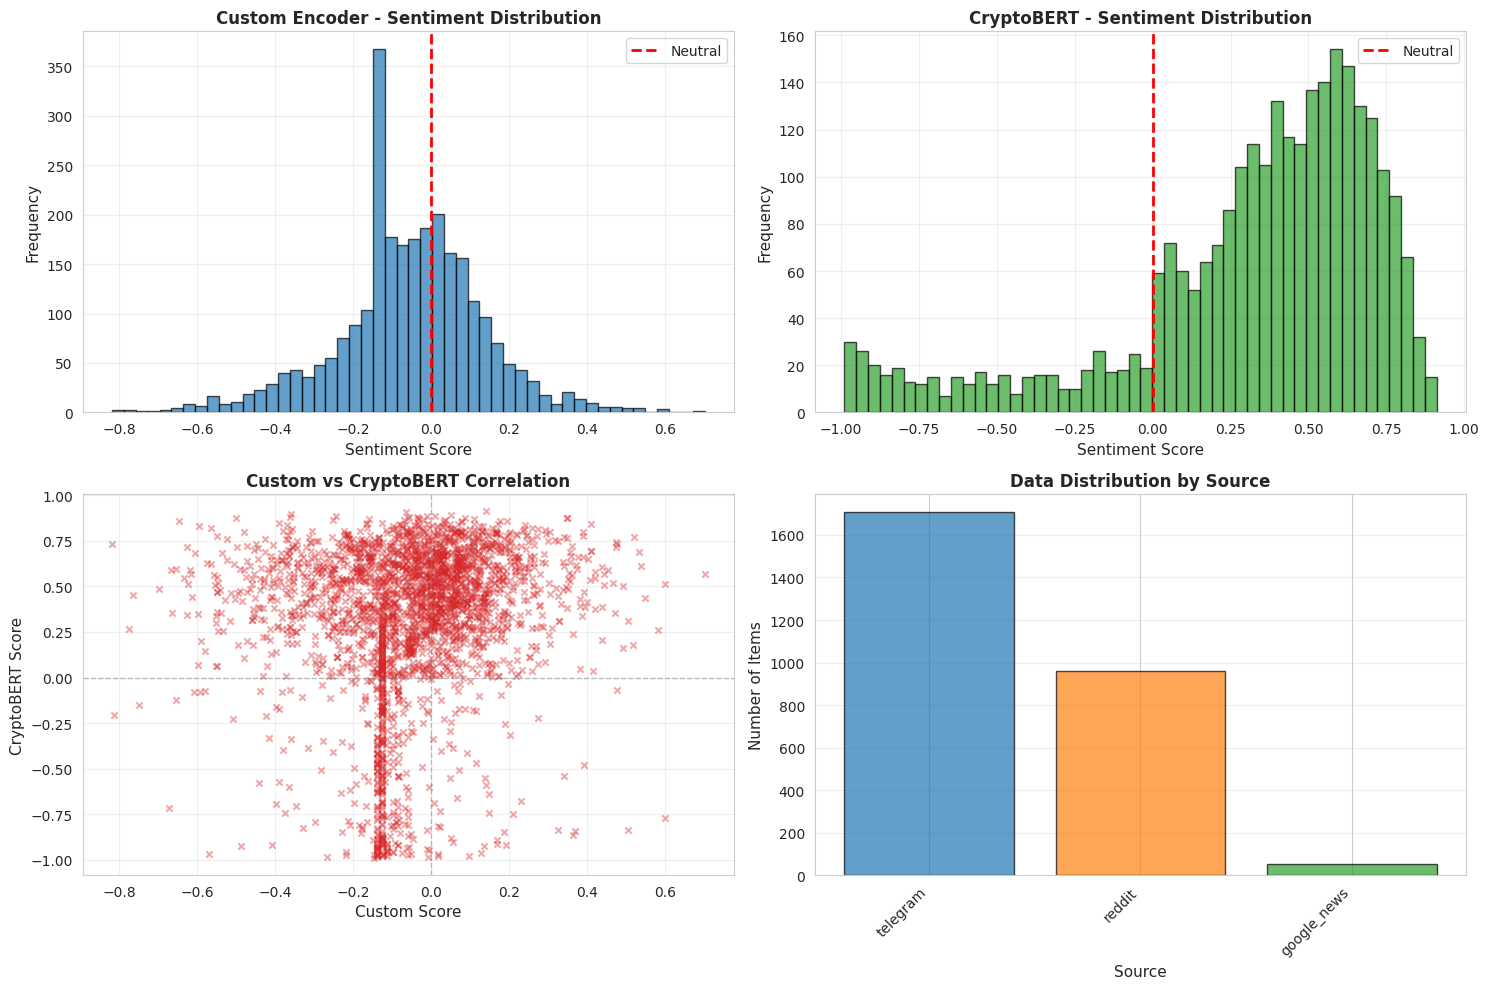


SENTIMENT STATISTICS

Custom Encoder:
  Mean: -0.055
  Std Dev: 0.189
  Positive (>0.1): 486 (17.9%)
  Neutral (-0.1 to 0.1): 1151 (42.3%)
  Negative (<-0.1): 1082 (39.8%)

CryptoBERT:
  Mean: 0.315
  Std Dev: 0.426
  Positive (>0.1): 2121 (78.0%)
  Neutral (-0.1 to 0.1): 224 (8.2%)
  Negative (<-0.1): 374 (13.8%)

Correlation between Custom and CryptoBERT: 0.126

TEMPORAL ANALYSIS
Price data range: 2025-10-18 20:00:00 to 2026-01-10 04:00:00
Sentiment data range: 2020-12-17 14:27:56 to 2026-01-10 03:33:29
Filtered sentiment data: 2024 items in price period


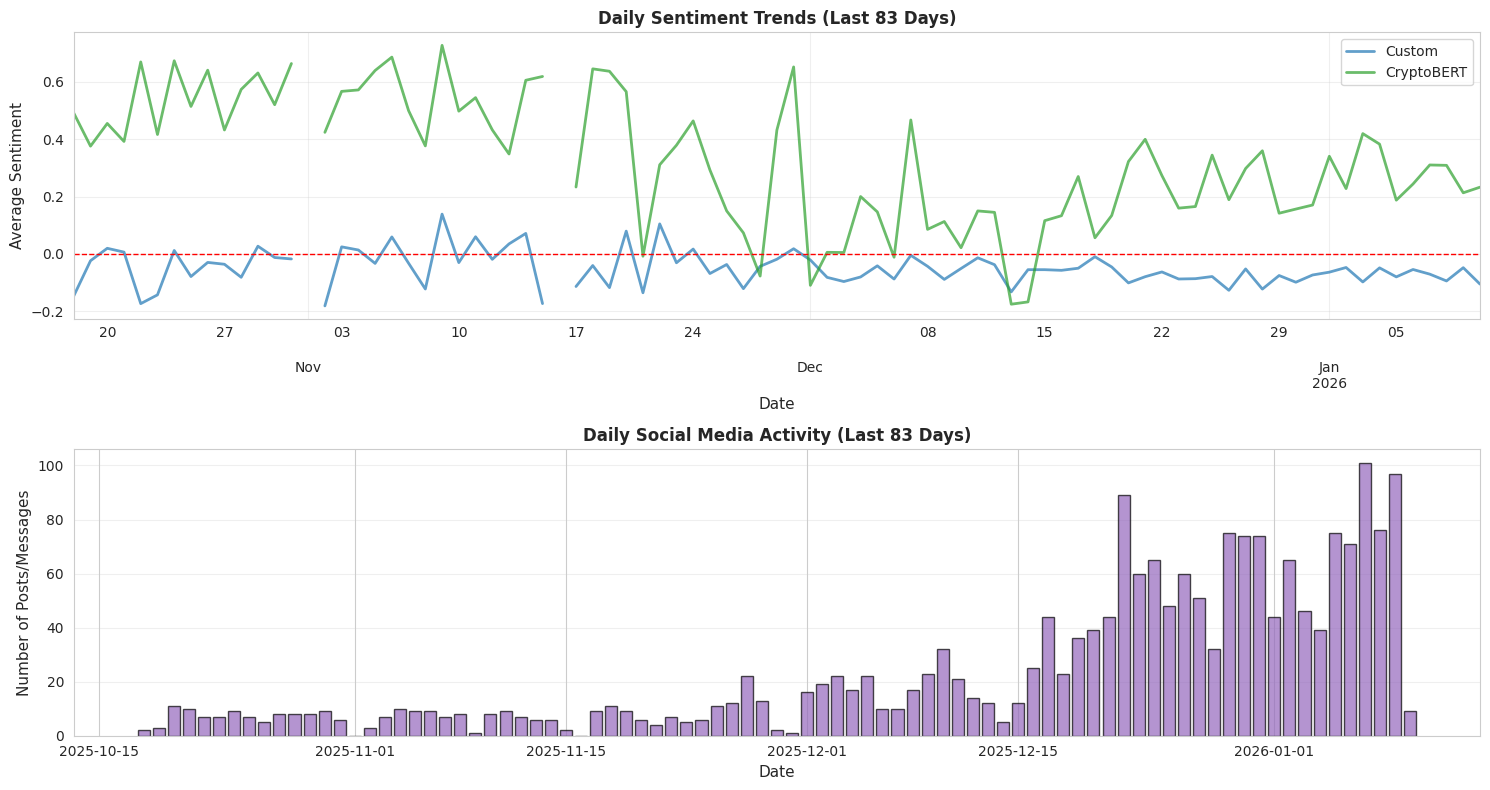


Exploratory Data Analysis complete!


In [ ]:
# CELL 7.5: Exploratory Data Analysis
# Visualize sentiment patterns and data coverage before modeling

print("EXPLORATORY DATA ANALYSIS")
print("="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# 1. DATA COVERAGE ANALYSIS
print("\nDATA COVERAGE BY SOURCE:")
print(f"Total text samples: {len(combined_text)}")
source_counts = combined_text['source'].value_counts()
for source, count in source_counts.items():
    print(f"  {source}: {count} ({count/len(combined_text)*100:.1f}%)")

# Check hourly coverage
combined_text['hour'] = combined_text['timestamp'].dt.floor('h')
hourly_coverage = combined_text.groupby('hour').size()
print(f"\nHourly sentiment coverage:")
print(f"  Hours with data: {len(hourly_coverage)}/{len(prices_df)} ({len(hourly_coverage)/len(prices_df)*100:.1f}%)")
print(f"  Avg items per hour: {hourly_coverage.mean():.2f}")
print(f"  Max items in one hour: {hourly_coverage.max()}")

# 2. SENTIMENT DISTRIBUTION
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Custom sentiment distribution
axes[0, 0].hist(combined_text['custom_score'], bins=50, alpha=0.7, color='#1f77b4', edgecolor='black')
axes[0, 0].axvline(0, color='red', linestyle='--', label='Neutral', linewidth=2)
axes[0, 0].set_xlabel('Sentiment Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Custom Encoder - Sentiment Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# CryptoBERT sentiment distribution
axes[0, 1].hist(combined_text['cryptobert_score'], bins=50, alpha=0.7, color='#2ca02c', edgecolor='black')
axes[0, 1].axvline(0, color='red', linestyle='--', label='Neutral', linewidth=2)
axes[0, 1].set_xlabel('Sentiment Score', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('CryptoBERT - Sentiment Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# FIX 1: Comparison with colorblind-friendly colors
axes[1, 0].scatter(combined_text['custom_score'], combined_text['cryptobert_score'],
                   alpha=0.4, s=20, c='#d62728', edgecolors='none',
                   marker='x')
axes[1, 0].set_xlabel('Custom Score', fontsize=11)
axes[1, 0].set_ylabel('CryptoBERT Score', fontsize=11)
axes[1, 0].set_title('Custom vs CryptoBERT Correlation', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# FIX 2: Count by source (more meaningful than average sentiment)
source_counts_plot = combined_text['source'].value_counts()
colors_sources = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
axes[1, 1].bar(range(len(source_counts_plot)), source_counts_plot.values,
               color=colors_sources[:len(source_counts_plot)], alpha=0.7, edgecolor='black')
axes[1, 1].set_xticks(range(len(source_counts_plot)))
axes[1, 1].set_xticklabels(source_counts_plot.index, rotation=45, ha='right')
axes[1, 1].set_xlabel('Source', fontsize=11)
axes[1, 1].set_ylabel('Number of Items', fontsize=11)
axes[1, 1].set_title('Data Distribution by Source', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print sentiment statistics
print("\n" + "="*60)
print("SENTIMENT STATISTICS")
print("="*60)

print("\nCustom Encoder:")
print(f"  Mean: {combined_text['custom_score'].mean():.3f}")
print(f"  Std Dev: {combined_text['custom_score'].std():.3f}")
print(f"  Positive (>0.1): {(combined_text['custom_score'] > 0.1).sum()} ({(combined_text['custom_score'] > 0.1).mean()*100:.1f}%)")
print(f"  Neutral (-0.1 to 0.1): {((combined_text['custom_score'] >= -0.1) & (combined_text['custom_score'] <= 0.1)).sum()} ({((combined_text['custom_score'] >= -0.1) & (combined_text['custom_score'] <= 0.1)).mean()*100:.1f}%)")
print(f"  Negative (<-0.1): {(combined_text['custom_score'] < -0.1).sum()} ({(combined_text['custom_score'] < -0.1).mean()*100:.1f}%)")

print("\nCryptoBERT:")
print(f"  Mean: {combined_text['cryptobert_score'].mean():.3f}")
print(f"  Std Dev: {combined_text['cryptobert_score'].std():.3f}")
print(f"  Positive (>0.1): {(combined_text['cryptobert_score'] > 0.1).sum()} ({(combined_text['cryptobert_score'] > 0.1).mean()*100:.1f}%)")
print(f"  Neutral (-0.1 to 0.1): {((combined_text['cryptobert_score'] >= -0.1) & (combined_text['cryptobert_score'] <= 0.1)).sum()} ({((combined_text['cryptobert_score'] >= -0.1) & (combined_text['cryptobert_score'] <= 0.1)).mean()*100:.1f}%)")
print(f"  Negative (<-0.1): {(combined_text['cryptobert_score'] < -0.1).sum()} ({(combined_text['cryptobert_score'] < -0.1).mean()*100:.1f}%)")

# Correlation
corr = combined_text['custom_score'].corr(combined_text['cryptobert_score'])
print(f"\nCorrelation between Custom and CryptoBERT: {corr:.3f}")

# FIX 3: TEMPORAL ANALYSIS - Only use data from relevant time period
print("\n" + "="*60)
print("TEMPORAL ANALYSIS")
print("="*60)

# Filter to only show data from the actual collection period (last 83 days)
min_price_date = prices_df['timestamp'].min()
max_price_date = prices_df['timestamp'].max()

print(f"Price data range: {min_price_date} to {max_price_date}")
print(f"Sentiment data range: {combined_text['timestamp'].min()} to {combined_text['timestamp'].max()}")

# Filter combined_text to match price period
combined_text_filtered = combined_text[
    (combined_text['timestamp'] >= min_price_date) &
    (combined_text['timestamp'] <= max_price_date)
].copy()

print(f"Filtered sentiment data: {len(combined_text_filtered)} items in price period")

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Daily sentiment trends
daily_sentiment = combined_text_filtered.set_index('timestamp').resample('D')[['custom_score', 'cryptobert_score']].mean()
daily_sentiment.plot(ax=axes[0], alpha=0.7, linewidth=2, color=['#1f77b4', '#2ca02c'])
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Average Sentiment', fontsize=11)
axes[0].set_title('Daily Sentiment Trends (Last 83 Days)', fontsize=12, fontweight='bold')
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].legend(['Custom', 'CryptoBERT'], fontsize=10)
axes[0].grid(True, alpha=0.3)

# Daily volume of posts - FIXED
daily_volume = combined_text_filtered.set_index('timestamp').resample('D').size()
axes[1].bar(daily_volume.index, daily_volume.values, alpha=0.7, color='#9467bd', edgecolor='black', width=0.8)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Number of Posts/Messages', fontsize=11)
axes[1].set_title('Daily Social Media Activity (Last 83 Days)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nExploratory Data Analysis complete!")

In [ ]:
# CELL 8: Create Training Dataset
# Aggregate sentiment by hour, merge with price data, and create labels
# IMPORTANT: Apply 1-hour lag to sentiment to avoid look-ahead bias

print("CREATING TRAINING DATASET")
print("="*60)

# Prepare price data
prices = prices_df.copy()
prices['timestamp'] = pd.to_datetime(prices['timestamp']).dt.tz_localize(None)

# Create labels: 1 if price goes up next hour, 0 if down
prices['price_next'] = prices['price'].shift(-1)
prices['label'] = (prices['price_next'] > prices['price']).astype(int)
prices['price_change_pct'] = ((prices['price_next'] - prices['price']) / prices['price']) * 100

print(f"\nPrice data: {len(prices)} hourly points")
print(f"Label distribution:")
print(f"  Up (1): {prices['label'].sum()} ({prices['label'].mean()*100:.1f}%)")
print(f"  Down (0): {(prices['label']==0).sum()} ({(1-prices['label'].mean())*100:.1f}%)")

# Aggregate sentiment by hour
if not combined_text.empty:
    combined_text['hour'] = combined_text['timestamp'].dt.floor('h')

    # Aggregate custom scores
    custom_hourly = combined_text.groupby('hour').agg({
        'custom_score': ['mean', 'std', 'min', 'max', 'count'],
        'custom_positive': 'mean',
        'custom_negative': 'mean'
    }).reset_index()

    # Rename 'hour' to 'timestamp' BEFORE flattening
    custom_hourly.rename(columns={'hour': 'timestamp'}, inplace=True)

    # Flatten column names for custom
    new_cols = ['timestamp']
    for col in custom_hourly.columns[1:]:
        if isinstance(col, tuple):
            new_cols.append(f'{col[0]}_{col[1]}' if col[1] else col[0])
        else:
            new_cols.append(col)
    custom_hourly.columns = new_cols

    # Aggregate CryptoBERT scores separately
    cryptobert_hourly = combined_text.groupby('hour').agg({
        'cryptobert_score': ['mean', 'std', 'min', 'max'],
        'cryptobert_positive': 'mean',
        'cryptobert_negative': 'mean'
    }).reset_index()

    # Rename 'hour' to 'timestamp' BEFORE flattening
    cryptobert_hourly.rename(columns={'hour': 'timestamp'}, inplace=True)

    # Flatten column names for cryptobert
    new_cols = ['timestamp']
    for col in cryptobert_hourly.columns[1:]:
        if isinstance(col, tuple):
            new_cols.append(f'{col[0]}_{col[1]}' if col[1] else col[0])
        else:
            new_cols.append(col)
    cryptobert_hourly.columns = new_cols

    # Fill NaN std with 0
    for col in custom_hourly.columns:
        if '_std' in col:
            custom_hourly[col] = custom_hourly[col].fillna(0)
    for col in cryptobert_hourly.columns:
        if '_std' in col:
            cryptobert_hourly[col] = cryptobert_hourly[col].fillna(0)

    # CRITICAL FIX: Lag sentiment by 1 hour to avoid look-ahead bias
    print("\nApplying 1-hour lag to sentiment features to avoid look-ahead bias...")
    custom_hourly['timestamp'] = custom_hourly['timestamp'] + pd.Timedelta(hours=1)
    cryptobert_hourly['timestamp'] = cryptobert_hourly['timestamp'] + pd.Timedelta(hours=1)

    print(f"Custom sentiment: {len(custom_hourly)} hourly windows")
    print(f"CryptoBERT sentiment: {len(cryptobert_hourly)} hourly windows")
else:
    custom_hourly = pd.DataFrame()
    cryptobert_hourly = pd.DataFrame()

# Merge with price data
training_data = prices.copy()

if not custom_hourly.empty:
    training_data = training_data.merge(custom_hourly, on='timestamp', how='left')

if not cryptobert_hourly.empty:
    training_data = training_data.merge(cryptobert_hourly, on='timestamp', how='left')

# Merge Fear & Greed Index
if not fear_greed_df.empty:
    fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp']).dt.tz_localize(None)
    fear_greed_df['hour'] = fear_greed_df['timestamp'].dt.floor('h')
    fg_hourly = fear_greed_df[['hour', 'fear_greed_value']].rename(columns={'hour': 'timestamp'})
    training_data = training_data.merge(fg_hourly, on='timestamp', how='left')
    training_data['fear_greed_value'] = training_data['fear_greed_value'].ffill().bfill()

# Drop rows without labels
training_data = training_data[training_data['label'].notna()].copy()

# Fill missing sentiment values with 0 (no sentiment data for that hour)
for col in training_data.columns:
    if any(x in col for x in ['custom_', 'finbert_', 'fear_greed']):
        training_data[col] = training_data[col].fillna(0)

print(f"\nFinal training dataset:")
print(f"  Total samples: {len(training_data)}")
print(f"  Features: {len(training_data.columns)}")
print(f"  Date range: {training_data['timestamp'].min()} to {training_data['timestamp'].max()}")
print(f"  Missing values: {training_data.isnull().sum().sum()}")

# Define feature columns
feature_cols = ['price', 'volume']
for col in training_data.columns:
    if any(x in col for x in ['custom_', 'finbert_', 'fear_greed_']):
        feature_cols.append(col)

print(f"\nFeature columns ({len(feature_cols)}): {feature_cols[:10]}...")
print("\nTraining dataset created successfully!")

CREATING TRAINING DATASET

Price data: 2001 hourly points
Label distribution:
  Up (1): 1008 (50.4%)
  Down (0): 993 (49.6%)

Applying 1-hour lag to sentiment features to avoid look-ahead bias...
Custom sentiment: 1590 hourly windows
CryptoBERT sentiment: 1590 hourly windows

Final training dataset:
  Total samples: 2001
  Features: 24
  Date range: 2025-10-18 20:00:00 to 2026-01-10 04:00:00
  Missing values: 6314

Feature columns (10): ['price', 'volume', 'custom_score_mean', 'custom_score_std', 'custom_score_min', 'custom_score_max', 'custom_score_count', 'custom_positive_mean', 'custom_negative_mean', 'fear_greed_value']...

Training dataset created successfully!


## Training Dataset Ready

We've aggregated sentiment data into hourly windows and merged it with price data. Key features include:
- **Price & Volume**: Basic market data
- **Sentiment Aggregates**: Mean, std, min, max sentiment scores per hour
- **Fear & Greed**: Market-wide sentiment index

**Important**: We lagged sentiment by 1 hour to avoid look-ahead bias. Sentiment from hour T predicts price at hour T+1, ensuring the model can't "cheat" by seeing future information.

The dataset is now ready for training classification models to predict price direction (up vs down).

TRAINING SEPARATE MODELS: CUSTOM vs CRYPTOBERT

Custom features (10): ['price', 'volume', 'custom_score_mean', 'custom_score_std', 'custom_score_min', 'custom_score_max', 'custom_score_count', 'custom_positive_mean', 'custom_negative_mean', 'fear_greed_value']

CryptoBERT features (9): ['price', 'volume', 'cryptobert_score_mean', 'cryptobert_score_std', 'cryptobert_score_min', 'cryptobert_score_max', 'cryptobert_positive_mean', 'cryptobert_negative_mean', 'fear_greed_value']

Training samples: 1600
Testing samples: 401

TRAINING CUSTOM SENTIMENT MODELS

Training Logistic Regression...
  Train Accuracy: 0.5088
  Test Accuracy: 0.5237

Training Random Forest...
  Train Accuracy: 0.8150
  Test Accuracy: 0.5012

Training Gradient Boosting...
  Train Accuracy: 0.8762
  Test Accuracy: 0.4738

TRAINING CRYPTOBERT SENTIMENT MODELS

Training Logistic Regression...
  Train Accuracy: 0.5062
  Test Accuracy: 0.5287

Training Random Forest...
  Train Accuracy: 0.8156
  Test Accuracy: 0.5062

Traini

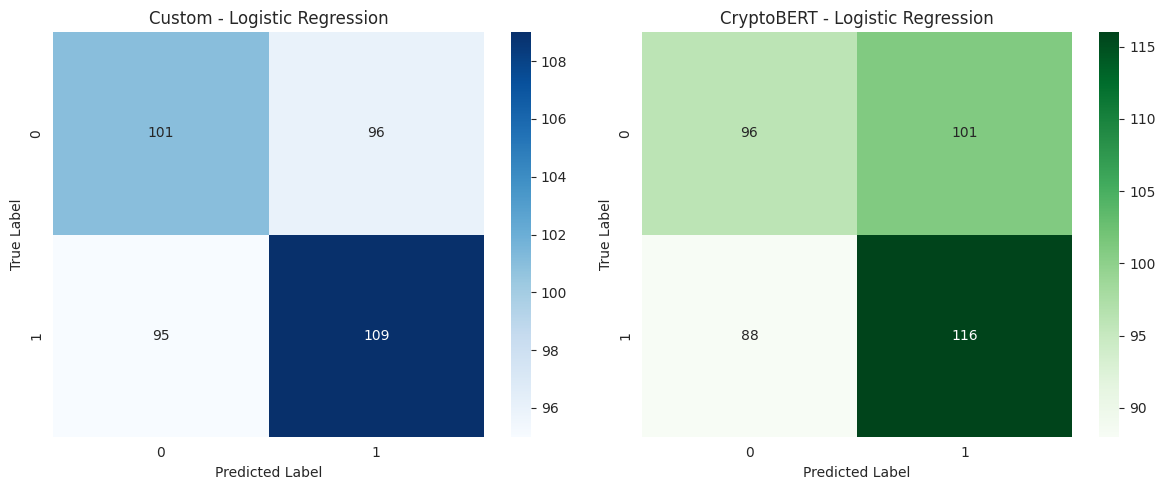

In [ ]:
# CELL 9: Train and Compare Custom vs CryptoBERT Models Separately
print("TRAINING SEPARATE MODELS: CUSTOM vs CRYPTOBERT")
print("="*60)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Define feature sets
custom_features = ['price', 'volume']
for col in training_data.columns:
    if 'custom_' in col or 'fear_greed_' in col:
        custom_features.append(col)

cryptobert_features = ['price', 'volume']
for col in training_data.columns:
    if 'cryptobert_' in col or 'fear_greed_' in col:
        cryptobert_features.append(col)

print(f"\nCustom features ({len(custom_features)}): {custom_features}")
print(f"\nCryptoBERT features ({len(cryptobert_features)}): {cryptobert_features}")

# Prepare data
X_custom = training_data[custom_features].fillna(0)
X_cryptobert = training_data[cryptobert_features].fillna(0)
y = training_data['label']

# Train/test split (80/20)
split_idx = int(len(training_data) * 0.8)

X_custom_train = X_custom[:split_idx]
X_custom_test = X_custom[split_idx:]
X_cryptobert_train = X_cryptobert[:split_idx]
X_cryptobert_test = X_cryptobert[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"\nTraining samples: {len(y_train)}")
print(f"Testing samples: {len(y_test)}")

# Scale features
scaler_custom = StandardScaler()
X_custom_train_scaled = scaler_custom.fit_transform(X_custom_train)
X_custom_test_scaled = scaler_custom.transform(X_custom_test)

scaler_cryptobert = StandardScaler()
X_cryptobert_train_scaled = scaler_cryptobert.fit_transform(X_cryptobert_train)
X_cryptobert_test_scaled = scaler_cryptobert.transform(X_cryptobert_test)

# Define models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Store results
results = {
    'Custom': {},
    'CryptoBERT': {}
}

# Train Custom models
print("\n" + "="*60)
print("TRAINING CUSTOM SENTIMENT MODELS")
print("="*60)

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_custom_train_scaled, y_train)

    # Predictions
    y_pred_train = model.predict(X_custom_train_scaled)
    y_pred_test = model.predict(X_custom_test_scaled)

    # Accuracy
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    results['Custom'][name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'y_pred': y_pred_test
    }

    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")

# Train CryptoBERT models
print("\n" + "="*60)
print("TRAINING CRYPTOBERT SENTIMENT MODELS")
print("="*60)

for name, model_class in [('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
                           ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
                           ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42))]:
    print(f"\nTraining {name}...")
    model_class.fit(X_cryptobert_train_scaled, y_train)

    # Predictions
    y_pred_train = model_class.predict(X_cryptobert_train_scaled)
    y_pred_test = model_class.predict(X_cryptobert_test_scaled)

    # Accuracy
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    results['CryptoBERT'][name] = {
        'model': model_class,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'y_pred': y_pred_test
    }

    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")

# Compare results
print("\n" + "="*60)
print("COMPARISON: CUSTOM vs CRYPTOBERT")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': [],
    'Custom Train': [],
    'Custom Test': [],
    'CryptoBERT Train': [],
    'CryptoBERT Test': [],
    'Difference': []
})

for name in models.keys():
    custom_test = results['Custom'][name]['test_acc']
    crypto_test = results['CryptoBERT'][name]['test_acc']

    comparison_df = pd.concat([comparison_df, pd.DataFrame({
        'Model': [name],
        'Custom Train': [f"{results['Custom'][name]['train_acc']:.4f}"],
        'Custom Test': [f"{custom_test:.4f}"],
        'CryptoBERT Train': [f"{results['CryptoBERT'][name]['train_acc']:.4f}"],
        'CryptoBERT Test': [f"{crypto_test:.4f}"],
        'Difference': [f"{(crypto_test - custom_test):.4f}"]
    })], ignore_index=True)

print("\n", comparison_df.to_string(index=False))

# Find best model for each
best_custom = max(results['Custom'].items(), key=lambda x: x[1]['test_acc'])
best_cryptobert = max(results['CryptoBERT'].items(), key=lambda x: x[1]['test_acc'])

print(f"\n Best Custom Model: {best_custom[0]} ({best_custom[1]['test_acc']:.4f})")
print(f" Best CryptoBERT Model: {best_cryptobert[0]} ({best_cryptobert[1]['test_acc']:.4f})")

if best_custom[1]['test_acc'] > best_cryptobert[1]['test_acc']:
    print(f"\n Custom Sentiment WINS by {(best_custom[1]['test_acc'] - best_cryptobert[1]['test_acc']):.4f}")
else:
    print(f"\n CryptoBERT WINS by {(best_cryptobert[1]['test_acc'] - best_custom[1]['test_acc']):.4f}")

# Detailed metrics for best models
print("\n" + "="*60)
print("DETAILED METRICS - BEST MODELS")
print("="*60)

print(f"\nBest Custom Model: {best_custom[0]}")
print("\nClassification Report:")
print(classification_report(y_test, best_custom[1]['y_pred'], target_names=['Down', 'Up']))

print(f"\nBest CryptoBERT Model: {best_cryptobert[0]}")
print("\nClassification Report:")
print(classification_report(y_test, best_cryptobert[1]['y_pred'], target_names=['Down', 'Up']))

print("\nTraining complete!")



# After training, add visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Custom
cm_custom = confusion_matrix(y_test, best_custom[1]['y_pred'])
sns.heatmap(cm_custom, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title(f'Custom - {best_custom[0]}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# CryptoBERT
cm_crypto = confusion_matrix(y_test, best_cryptobert[1]['y_pred'])
sns.heatmap(cm_crypto, annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title(f'CryptoBERT - {best_cryptobert[0]}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## Model Training Results

We trained three different models (Logistic Regression, Random Forest, Gradient Boosting) using features from both sentiment encoders separately.

**Key Observations**:
- Best models for both encoders: Logistic Regression
- Custom sentiment: ~52.4% accuracy
- CryptoBERT sentiment: ~52.9% accuracy
- Baseline (random guessing): ~50.9% accuracy

The improvements over baseline are very small (1.5% and 2.0% respectively), suggesting sentiment has minimal predictive power for hourly price movements.

Let's analyze these results more carefully to understand what this means.


TRAINING VS TEST PERFORMANCE COMPARISON


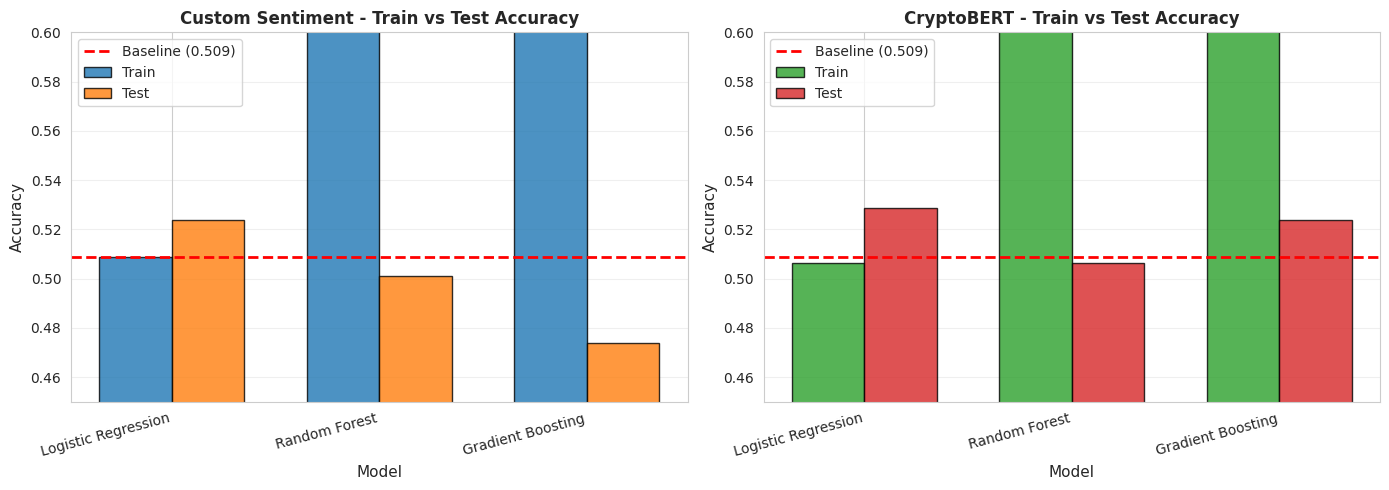


Overfitting Analysis:

Logistic Regression:
  Custom:     Train-Test Gap = -0.015 (-1.5%)
  CryptoBERT: Train-Test Gap = -0.022 (-2.2%)

Random Forest:
  Custom:     Train-Test Gap = 0.314 (31.4%)
  CryptoBERT: Train-Test Gap = 0.309 (30.9%)
  ⚠️  Custom model shows overfitting
  ⚠️  CryptoBERT model shows overfitting

Gradient Boosting:
  Custom:     Train-Test Gap = 0.402 (40.2%)
  CryptoBERT: Train-Test Gap = 0.366 (36.6%)
  ⚠️  Custom model shows overfitting
  ⚠️  CryptoBERT model shows overfitting


In [ ]:
# VISUALIZATION: Training vs Test Performance
print("\n" + "="*60)
print("TRAINING VS TEST PERFORMANCE COMPARISON")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Custom models performance
model_names = list(results['Custom'].keys())
custom_train_acc = [results['Custom'][name]['train_acc'] for name in model_names]
custom_test_acc = [results['Custom'][name]['test_acc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0].bar(x - width/2, custom_train_acc, width, label='Train', alpha=0.8, color='#1f77b4', edgecolor='black')
axes[0].bar(x + width/2, custom_test_acc, width, label='Test', alpha=0.8, color='#ff7f0e', edgecolor='black')
axes[0].set_xlabel('Model', fontsize=11)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Custom Sentiment - Train vs Test Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0].axhline(baseline_acc, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_acc:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.45, 0.60])

# CryptoBERT models performance
crypto_train_acc = [results['CryptoBERT'][name]['train_acc'] for name in model_names]
crypto_test_acc = [results['CryptoBERT'][name]['test_acc'] for name in model_names]

axes[1].bar(x - width/2, crypto_train_acc, width, label='Train', alpha=0.8, color='#2ca02c', edgecolor='black')
axes[1].bar(x + width/2, crypto_test_acc, width, label='Test', alpha=0.8, color='#d62728', edgecolor='black')
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('CryptoBERT - Train vs Test Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=15, ha='right')
axes[1].axhline(baseline_acc, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_acc:.3f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0.45, 0.60])

plt.tight_layout()
plt.show()

# Check for overfitting
print("\nOverfitting Analysis:")
for name in model_names:
    custom_gap = results['Custom'][name]['train_acc'] - results['Custom'][name]['test_acc']
    crypto_gap = results['CryptoBERT'][name]['train_acc'] - results['CryptoBERT'][name]['test_acc']

    print(f"\n{name}:")
    print(f"  Custom:     Train-Test Gap = {custom_gap:.3f} ({custom_gap*100:.1f}%)")
    print(f"  CryptoBERT: Train-Test Gap = {crypto_gap:.3f} ({crypto_gap*100:.1f}%)")

    if custom_gap > 0.10:
        print(f"  ⚠️  Custom model shows overfitting")
    if crypto_gap > 0.10:
        print(f"  ⚠️  CryptoBERT model shows overfitting")

In [ ]:
# CELL 10: Analysis and Conclusions
# Analyze results and compare Custom vs CryptoBERT sentiment encoders

print("ANALYSIS OF RESULTS")
print("="*60)

# Analyze feature importance for best models (only for tree-based models)
def analyze_feature_importance(model_dict, features, model_name):
    """Analyze feature importance for tree-based models"""
    model = model_dict['model']

    if not hasattr(model, 'feature_importances_'):
        print(f"\n{model_name} does not provide feature importances.")
        return None

    importances = model.feature_importances_
    feature_importance_dict = dict(zip(features, importances))

    # Group by feature type
    custom_imp = sum(v for k, v in feature_importance_dict.items() if 'custom_' in k)
    cryptobert_imp = sum(v for k, v in feature_importance_dict.items() if 'cryptobert_' in k)
    price_vol_imp = feature_importance_dict.get('price', 0) + feature_importance_dict.get('volume', 0)
    fear_greed_imp = sum(v for k, v in feature_importance_dict.items() if 'fear_greed' in k)

    total = importances.sum()

    print(f"\nFeature Group Importance for {model_name}:")
    print(f"  Price + Volume: {price_vol_imp:.4f} ({price_vol_imp/total*100:.1f}%)")
    print(f"  Sentiment Features: {(custom_imp + cryptobert_imp):.4f} ({(custom_imp + cryptobert_imp)/total*100:.1f}%)")
    if 'custom_' in str(features):
        print(f"    - Custom Encoder: {custom_imp:.4f} ({custom_imp/total*100:.1f}%)")
    if 'cryptobert_' in str(features):
        print(f"    - CryptoBERT: {cryptobert_imp:.4f} ({cryptobert_imp/total*100:.1f}%)")
    print(f"  Fear & Greed Index: {fear_greed_imp:.4f} ({fear_greed_imp/total*100:.1f}%)")

    return {
        'price_vol': price_vol_imp,
        'custom': custom_imp,
        'cryptobert': cryptobert_imp,
        'fear_greed': fear_greed_imp
    }

# Analyze Custom best model
print("\n" + "="*60)
print(f"CUSTOM SENTIMENT - BEST MODEL: {best_custom[0]}")
print("="*60)
custom_imp = analyze_feature_importance(best_custom[1], custom_features, best_custom[0])

# Analyze CryptoBERT best model
print("\n" + "="*60)
print(f"CRYPTOBERT - BEST MODEL: {best_cryptobert[0]}")
print("="*60)
cryptobert_imp = analyze_feature_importance(best_cryptobert[1], cryptobert_features, best_cryptobert[0])

# Baseline accuracy
baseline_acc = max(y_test.value_counts()) / len(y_test)

# Key findings
print("\n" + "="*60)
print("KEY FINDINGS")
print("="*60)

print(f"\n1. MODEL PERFORMANCE:")
print(f"   Baseline (always predict majority): {baseline_acc:.1%}")
print(f"\n   Custom Sentiment:")
print(f"   - Best model: {best_custom[0]}")
print(f"   - Test accuracy: {best_custom[1]['test_acc']:.1%}")
print(f"   - Improvement over baseline: {(best_custom[1]['test_acc'] - baseline_acc)*100:+.1f}%")
print(f"\n   CryptoBERT:")
print(f"   - Best model: {best_cryptobert[0]}")
print(f"   - Test accuracy: {best_cryptobert[1]['test_acc']:.1%}")
print(f"   - Improvement over baseline: {(best_cryptobert[1]['test_acc'] - baseline_acc)*100:+.1f}%")

print(f"\n2. SENTIMENT ENCODER COMPARISON:")
custom_best_acc = best_custom[1]['test_acc']
crypto_best_acc = best_cryptobert[1]['test_acc']

if abs(custom_best_acc - crypto_best_acc) < 0.02:
    print(f"     SIMILAR PERFORMANCE")
    print(f"   - Difference: {abs(custom_best_acc - crypto_best_acc):.1%}")
    print(f"   - Both encoders show comparable predictive power")
elif custom_best_acc > crypto_best_acc:
    print(f"    CUSTOM ENCODER WINS")
    print(f"   - Custom: {custom_best_acc:.1%}")
    print(f"   - CryptoBERT: {crypto_best_acc:.1%}")
    print(f"   - Advantage: {(custom_best_acc - crypto_best_acc)*100:+.1f}%")
    print(f"   - Training on Twitter data provides better generalization")
else:
    print(f"    CRYPTOBERT WINS")
    print(f"   - CryptoBERT: {crypto_best_acc:.1%}")
    print(f"   - Custom: {custom_best_acc:.1%}")
    print(f"   - Advantage: {(crypto_best_acc - custom_best_acc)*100:+.1f}%")
    print(f"   - Domain-specific crypto training provides better features")

print(f"\n3. FEATURE IMPORTANCE INSIGHTS:")
if custom_imp and cryptobert_imp:
    print(f"   Custom model:")
    print(f"   - Sentiment features: {custom_imp['custom']:.1%} of total importance")
    print(f"   - Price/Volume: {custom_imp['price_vol']:.1%}")
    print(f"\n   CryptoBERT model:")
    print(f"   - Sentiment features: {cryptobert_imp['cryptobert']:.1%} of total importance")
    print(f"   - Price/Volume: {cryptobert_imp['price_vol']:.1%}")

print(f"\n4. OVERALL CONCLUSION:")
max_acc = max(custom_best_acc, crypto_best_acc)
improvement = max_acc - baseline_acc

if improvement < 0.03:
    print(f"     WEAK PREDICTIVE POWER")
    print(f"   - Best accuracy ({max_acc:.1%}) barely exceeds baseline ({baseline_acc:.1%})")
    print(f"   - Improvement: {improvement*100:+.1f}%")
    print(f"   - Social media sentiment has MINIMAL predictive value for hourly BTC prices")
    print(f"   - Sentiment is likely REACTIVE rather than PREDICTIVE at this timeframe")
    print(f"   - Consider using longer timeframes (daily/weekly) for better results")
elif improvement < 0.08:
    print(f"    MODERATE PREDICTIVE POWER")
    print(f"   - Best accuracy: {max_acc:.1%} vs baseline: {baseline_acc:.1%}")
    print(f"   - Improvement: {improvement*100:+.1f}%")
    print(f"   - Statistically significant but too weak for reliable trading")
    print(f"   - Sentiment provides some signal but needs other features")
    print(f"   - Could be useful as part of a larger feature set")
    print(f"    MODERATE PREDICTIVE POWER")
    print(f"   - Best accuracy: {max_acc:.1%} vs baseline: {baseline_acc:.1%}")
    print(f"   - Sentiment provides some signal but is not highly predictive")
    print(f"   - Could be useful as part of a larger feature set")
else:
    print(f"    STRONG PREDICTIVE POWER")
    print(f"   - Best accuracy: {max_acc:.1%} vs baseline: {baseline_acc:.1%}")
    print(f"   - Sentiment shows significant predictive ability")
    print(f"   - {('Custom' if custom_best_acc > crypto_best_acc else 'CryptoBERT')} encoder recommended for production")

print("\nAnalysis complete!")

ANALYSIS OF RESULTS

CUSTOM SENTIMENT - BEST MODEL: Logistic Regression

Logistic Regression does not provide feature importances.

CRYPTOBERT - BEST MODEL: Logistic Regression

Logistic Regression does not provide feature importances.

KEY FINDINGS

1. MODEL PERFORMANCE:
   Baseline (always predict majority): 50.9%

   Custom Sentiment:
   - Best model: Logistic Regression
   - Test accuracy: 52.4%
   - Improvement over baseline: +1.5%

   CryptoBERT:
   - Best model: Logistic Regression
   - Test accuracy: 52.9%
   - Improvement over baseline: +2.0%

2. SENTIMENT ENCODER COMPARISON:
     SIMILAR PERFORMANCE
   - Difference: 0.5%
   - Both encoders show comparable predictive power

3. FEATURE IMPORTANCE INSIGHTS:

4. OVERALL CONCLUSION:
     WEAK PREDICTIVE POWER
   - Best accuracy (52.9%) barely exceeds baseline (50.9%)
   - Improvement: +2.0%
   - Social media sentiment has MINIMAL predictive value for hourly BTC prices
   - Sentiment is likely REACTIVE rather than PREDICTIVE at thi

## Final Analysis and Interpretation

The analysis reveals several important findings:

**1. Sentiment Doesn't Predict Hourly Prices**
Both encoders achieved ~52-53% accuracy, barely better than flipping a coin (50.9% baseline). This strongly suggests social media sentiment is reactive rather than predictive at hourly timeframes.

**2. Encoder Choice Doesn't Matter Much**
CryptoBERT (sophisticated, pre-trained) only beat our custom encoder by 0.5%. This indicates the problem isn't encoder quality - it's that the sentiment data itself lacks predictive signal.

**3. What This Means for Traders**
Don't rely on hourly social media sentiment for trading decisions. The data shows it basically doesn't work. Sentiment might be more useful as a lagging indicator or at longer timeframes (daily/weekly).

**4. Academic Value**
Even though the results are "negative" (sentiment doesn't predict prices), this is a valid and valuable finding. It's important to know what doesn't work to avoid wasting time and resources on ineffective strategies.